## Example for a CNN-LSTM model to predict BTC close price over next 15 min

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Mounted at /content/drive


In [ ]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 3.1 MB/s 
     |████████████████████████████████| 70 kB 9.7 MB/s 
     |████████████████████████████████| 112 kB 67.9 MB/s 
     |████████████████████████████████| 1.1 MB 56.1 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
     |████████████████████████████████| 288 kB 81.6 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 
     |████████████████████████████████| 271 kB 87.8 MB/s 
     |████████████████████████████████| 144 kB 84.6 MB/s 
     |████████████████████████████████| 749 kB 74.2 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2


In [ ]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu
import src.sats2backtest as s2b


# settings for reproducible results
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [ ]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')

In [ ]:
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'

In [ ]:
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')

In [ ]:
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)

In [ ]:
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (169606, 8)


In [ ]:
ldata_df

,timestamp,OpenBitcoin,HighBitcoin,LowBitcoin,CloseBitcoin,VolumeBitcoin,CountBitcoin,Date,Future Date
timestamp,,,,,,,,,
1502942400,1502942400,4261.48,4280.56,4261.48,4261.48,2.189061,9.0,2017-08-17 04:01:00,2017-08-17 04:15:00
1502943300,1502943300,4261.48,4270.41,4261.32,4261.45,9.119865,40.0,2017-08-17 04:16:00,2017-08-17 04:30:00
1502944200,1502944200,4280.00,4310.07,4267.99,4310.07,21.923552,58.0,2017-08-17 04:31:00,2017-08-17 04:45:00
1502945100,1502945100,4310.07,4313.62,4291.37,4308.83,13.948531,64.0,2017-08-17 04:46:00,2017-08-17 05:00:00
1502946000,1502946000,4308.83,4328.69,4304.31,4304.31,5.101153,44.0,2017-08-17 05:01:00,2017-08-17 05:15:00
...,...,...,...,...,...,...,...,...,...
1656084600,1656084600,20987.80,20999.98,20822.90,20871.55,1227.157500,18627.0,2022-06-24 15:31:00,2022-06-24 15:45:00
1656085500,1656085500,20871.55,20931.57,20832.02,20884.17,824.751160,14650.0,2022-06-24 15:46:00,2022-06-24 16:00:00
1656086400,1656086400,20884.17,20944.51,20855.51,20866.06,1046.785700,15561.0,2022-06-24 16:01:00,2022-06-24 16:15:00


### Plot wick Candles and build features from technical analysis

In [ ]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.candles

,Low,High,Open,Close,Volume
Date,,,,,
2017-08-17 04:01:00,4261.48,4280.56,4261.48,4261.48,2.189061
2017-08-17 04:16:00,4261.32,4270.41,4261.48,4261.45,9.119865
2017-08-17 04:31:00,4267.99,4310.07,4280.00,4310.07,21.923552
2017-08-17 04:46:00,4291.37,4313.62,4310.07,4308.83,13.948531
2017-08-17 05:01:00,4304.31,4328.69,4308.83,4304.31,5.101153
...,...,...,...,...,...
2022-06-24 15:31:00,20822.90,20999.98,20987.80,20871.55,1227.157500
2022-06-24 15:46:00,20832.02,20931.57,20871.55,20884.17,824.751160
2022-06-24 16:01:00,20855.51,20944.51,20884.17,20866.06,1046.785700


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

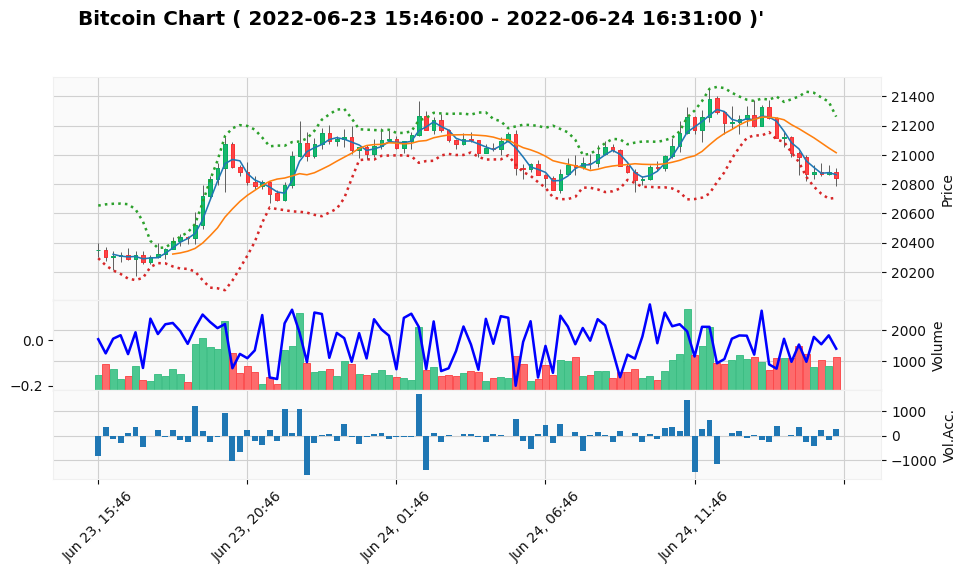

In [ ]:
can_btc.buildfeatures()
can_btc.ta_fullplot()

# Generate normalized timeseries

In [ ]:
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 50000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()

Candles Normalized
Extracted last 50000 steps
Generated time-series
Normalized 'candles_norm' with shape : (50000, 9)
Feature data 'x_candles' with size : 49952
Feature data with time intervals 'x_time' with size : 49952


In [ ]:
ts_btc.x_candles
ts_btc.x_time
ts_btc.scaler
ts_btc.y[-10:]

[0.3678114202209749,
 0.36655677105384166,
 0.3666259679600115,
 0.36566294733296006,
 0.36541511315059894,
 0.36435676468044237,
 0.3644716679641087,
 0.3643067790205907,
 0.3644797712860155,
 0.3640996435448847]

## Train a CNN-LSTM model 

In [ ]:
btc_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 0.9)

In [ ]:
btc_model.sats2model()
btc_model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 candles (InputLayer)           [(None, 48, 9)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 48, 32)       896         ['candles[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 48, 32)       2048        ['candles[0][0]']                
                                                                                                  
 conv1d_4 (Conv1D)              (None, 48, 32)       3776        ['candles[0][0]']                
                                                                                              

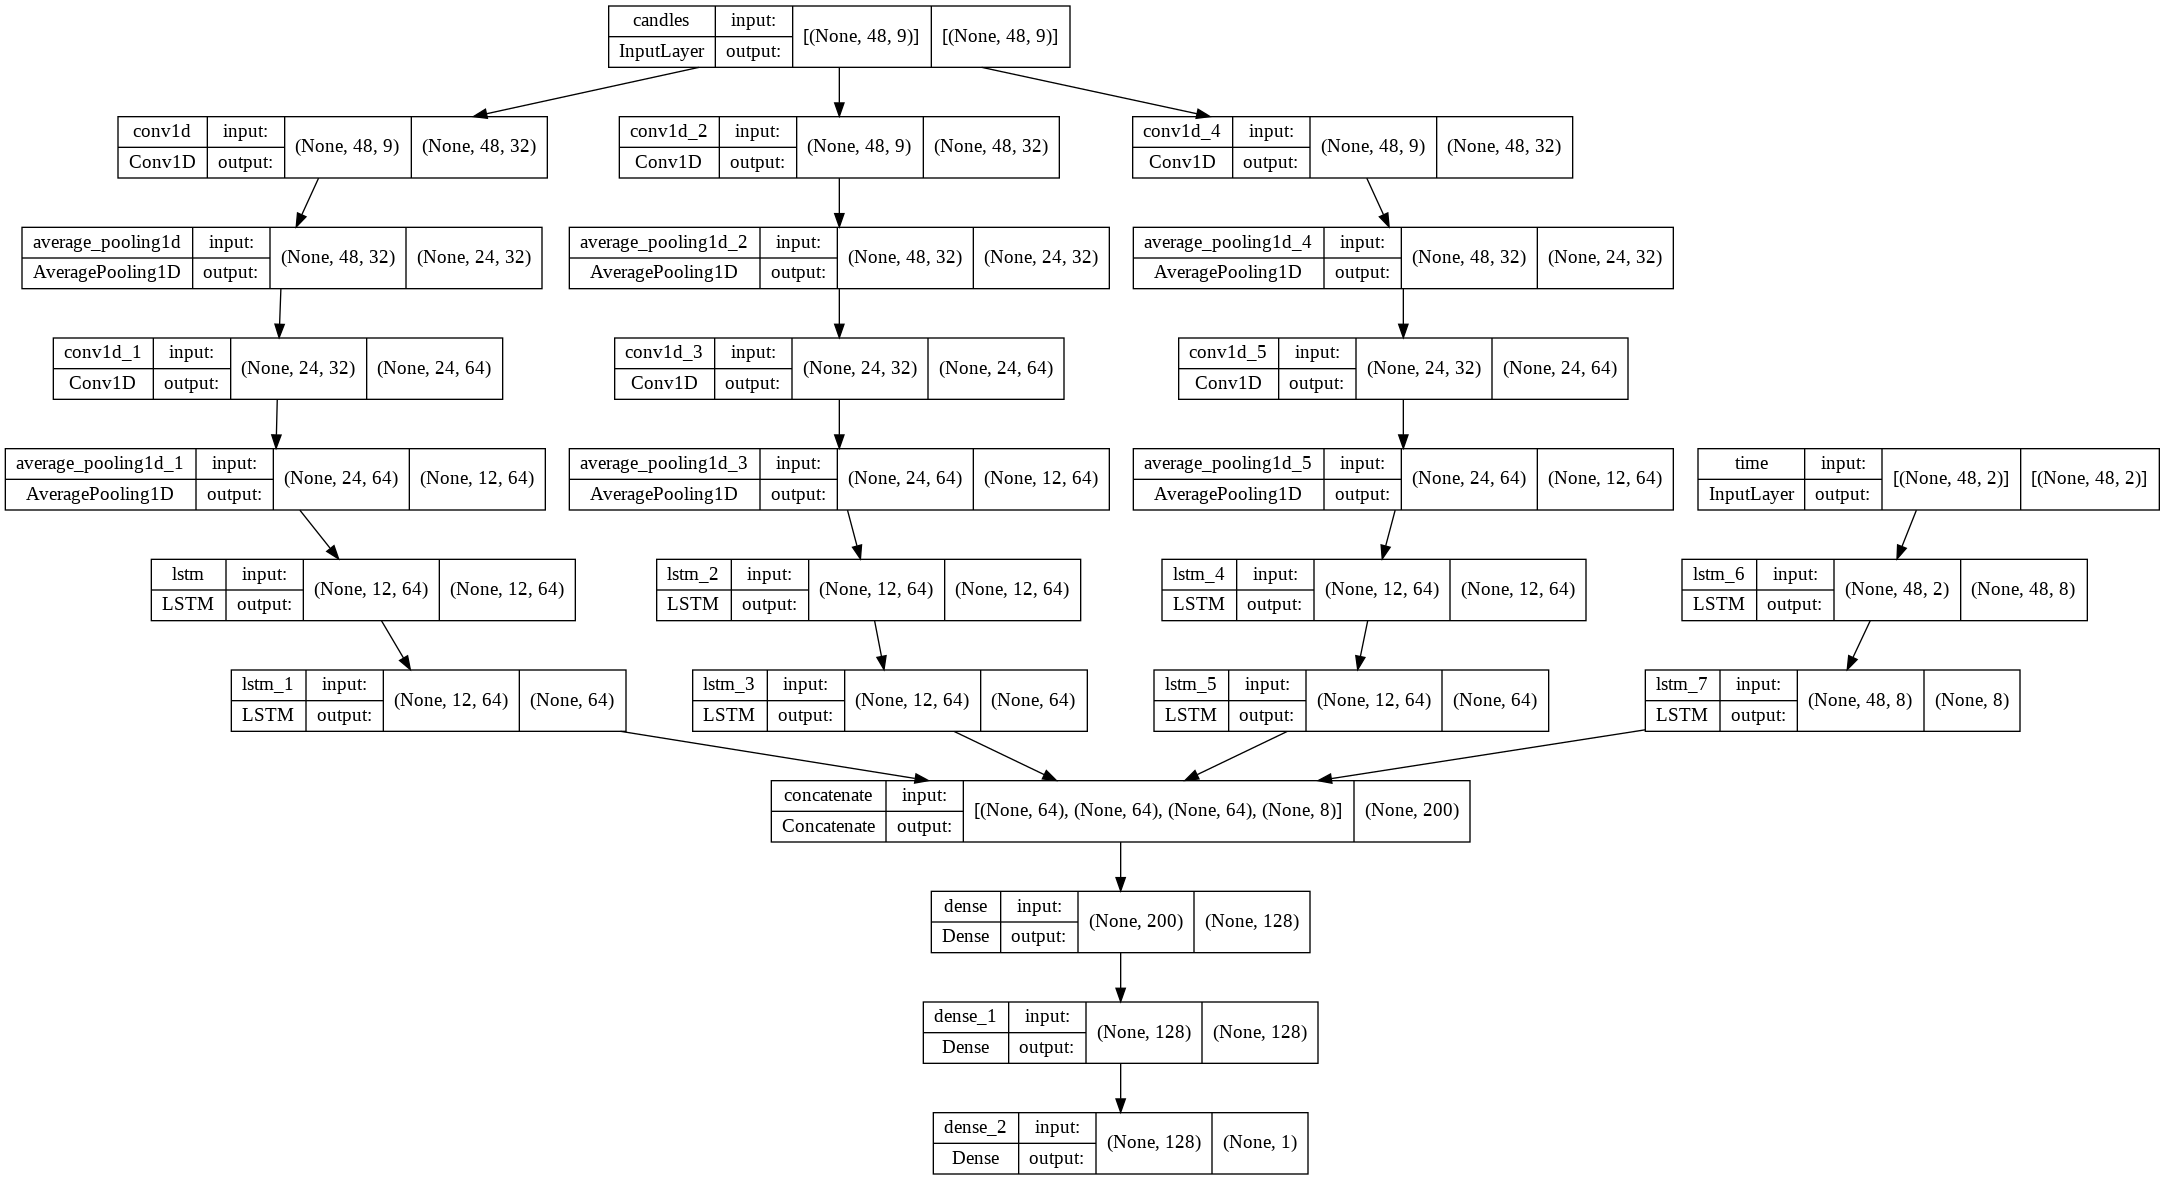

In [ ]:
keras.utils.plot_model(btc_model.model, "conv_lstm_net.png", show_shapes=True)

In [ ]:
model_name = "model/LSTM_CNN_model"
btc_model.sats2train(model_name,save_model = False)

Epoch 1/20
11/11 [==============================] - 26s 443ms/step - loss: 0.2049 - val_loss: 0.1457
Epoch 2/20
11/11 [==============================] - 2s 161ms/step - loss: 0.0546 - val_loss: 0.0748
Epoch 3/20
11/11 [==============================] - 1s 101ms/step - loss: 0.0369 - val_loss: 0.0677
Epoch 4/20
11/11 [==============================] - 1s 98ms/step - loss: 0.0209 - val_loss: 0.0501
Epoch 5/20
11/11 [==============================] - 1s 89ms/step - loss: 0.0319 - val_loss: 0.0292
Epoch 6/20
11/11 [==============================] - 1s 89ms/step - loss: 0.0229 - val_loss: 0.0274
Epoch 7/20
11/11 [==============================] - 1s 101ms/step - loss: 0.0151 - val_loss: 0.0306
Epoch 8/20
11/11 [==============================] - 1s 89ms/step - loss: 0.0192 - val_loss: 0.0075
Epoch 9/20
11/11 [==============================] - 1s 89ms/step - loss: 0.0164 - val_loss: 0.0055
Epoch 10/20
11/11 [==============================] - 1s 90ms/step - loss: 0.0156 - val_loss: 0.0150
Epoc

INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


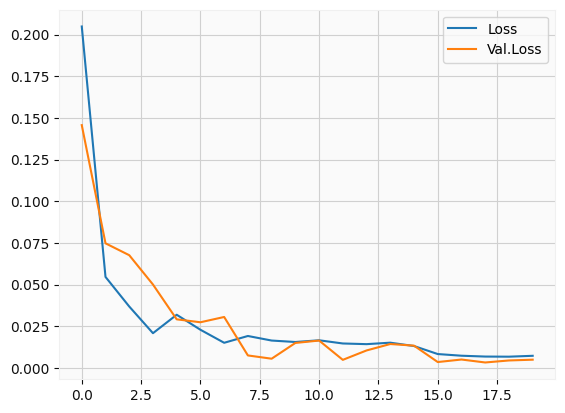

In [ ]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [ ]:
btc_model.sats2pred(predict_on_test = True)

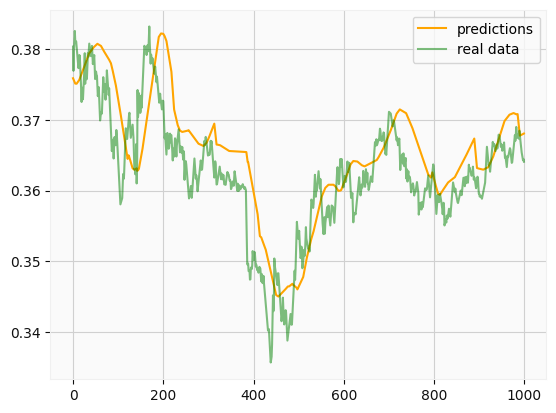

In [ ]:
plt.plot(btc_model.preds[-1000:], color='orange', label='predictions')
plt.plot(btc_model.y_test[-1000:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [ ]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(ts_btc.scaler, ts_btc.candles, btc_model.preds)

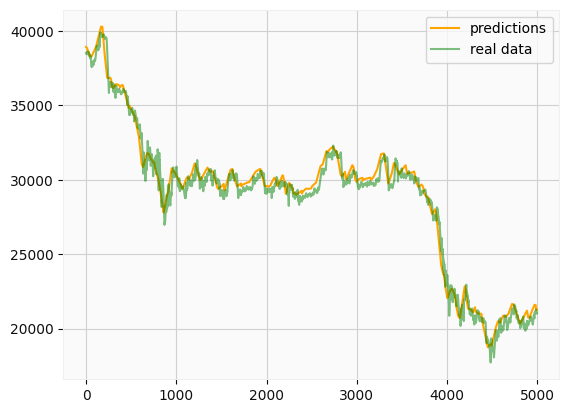

In [ ]:
plt.plot(preds[0:len(ts_btc.x_candles)-btc_model.split_point], color='orange', label='predictions')
plt.plot(true_vals[btc_model.split_point:len(ts_btc.x_candles)], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

## Back-testing buy or do nothing, i.e. up-only

Fee: 0.025
----------------------
Buy      702 ( 436 ok 266 ko )
No-op    4294
Wallet   26866.375500000035
Drawback -791.7407499999965
Total earned 26866.375500000035


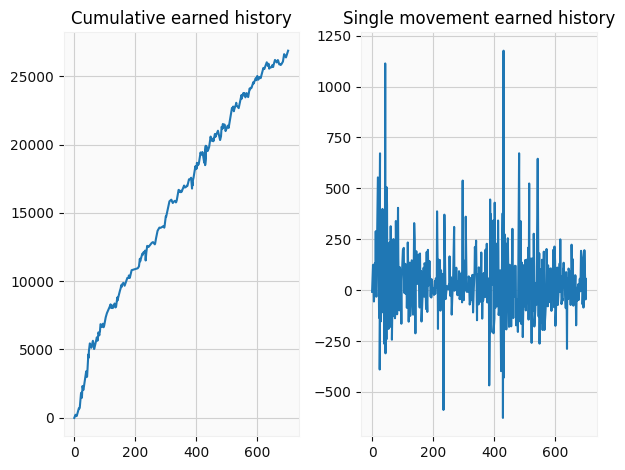

In [ ]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = 1)
df_preds_true.dropna().plot()

In [ ]:
total_wallet_history, single_wallet_history, wallet, kelly_frac = s2b.backtest_df(df_preds_true.dropna(), ts_btc.step_back, long_short = "long", fee=0.025)
s2b.show_backtest_results(wallet,total_wallet_history,single_wallet_history)

## Train for more epochs

In [ ]:
preds_old = btc_model.preds
y_test_old = btc_model.y_test

In [ ]:
btc_model.sats2train(model_name, save_model = False, epochs = 100)

Epoch 1/100
11/11 [==============================] - 1s 104ms/step - loss: 0.0074 - val_loss: 0.0046
Epoch 2/100
11/11 [==============================] - 1s 89ms/step - loss: 0.0074 - val_loss: 0.0070
Epoch 3/100
11/11 [==============================] - 1s 89ms/step - loss: 0.0076 - val_loss: 0.0041
Epoch 4/100
11/11 [==============================] - 1s 89ms/step - loss: 0.0075 - val_loss: 0.0068
Epoch 5/100
11/11 [==============================] - 1s 89ms/step - loss: 0.0074 - val_loss: 0.0045
Epoch 6/100
11/11 [==============================] - 1s 89ms/step - loss: 0.0075 - val_loss: 0.0069
Epoch 7/100
11/11 [==============================] - 1s 89ms/step - loss: 0.0074 - val_loss: 0.0042
Epoch 8/100
11/11 [==============================] - 1s 101ms/step - loss: 0.0073 - val_loss: 0.0062
Epoch 9/100
11/11 [==============================] - 1s 89ms/step - loss: 0.0074 - val_loss: 0.0046
Epoch 10/100
11/11 [==============================] - 1s 98ms/step - loss: 0.0072 - val_loss: 0.00

INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


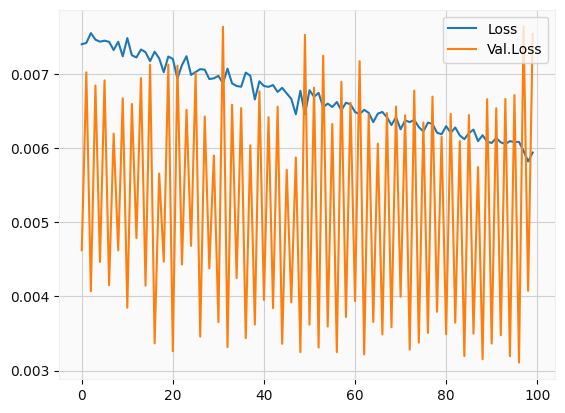

In [ ]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [ ]:
btc_model.sats2pred(predict_on_test = True)

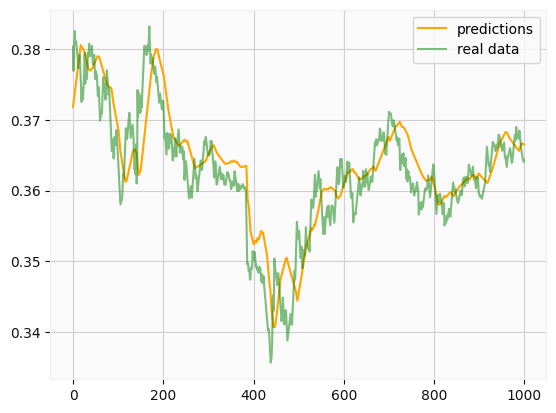

In [ ]:
plt.plot(btc_model.preds[-1000:], color='orange', label='predictions')
plt.plot(btc_model.y_test[-1000:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [ ]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(ts_btc.scaler, ts_btc.candles, btc_model.preds)

Fee: 0.025
----------------------
Buy      328 ( 197 ok 131 ko )
No-op    4668
Wallet   10889.410749999979
Drawback -927.1227499999984
Total earned 10889.410749999979


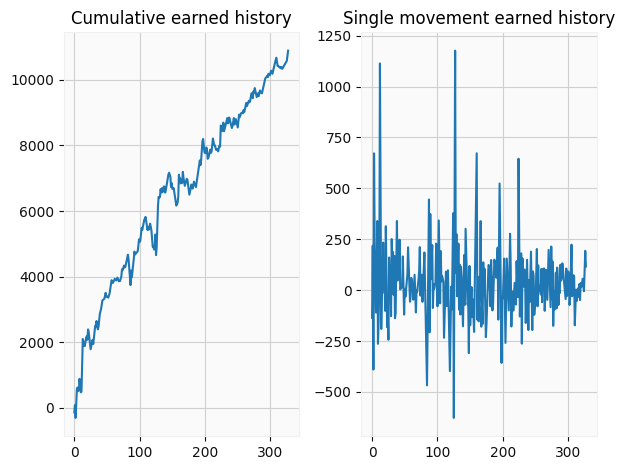

In [ ]:
df_preds_true = tu.merge_true_preds(can_btc.candles, preds, period=+1)

wallet_hist_df, wallet, kelly_frac = s2b.backtest_df(df_preds_true.dropna(), step_back=+ 2,
                                                     long_short="long", fee=0.025, cutoff_long=20., cutoff_short=20.0)
s2b.show_backtest_results(wallet, wallet_hist_df)


In [ ]:
df_pred_exp = pd.DataFrame(np.array([preds,true_vals[-len(preds):]]).T,columns=["Predicted","Expected"])

df_pred_exp["Return Expected"] = tu.log_return(df_pred_exp["Expected"],periods=-1)
df_pred_exp["Return Predicted"] = tu.log_return(df_pred_exp["Predicted"],periods=-1)


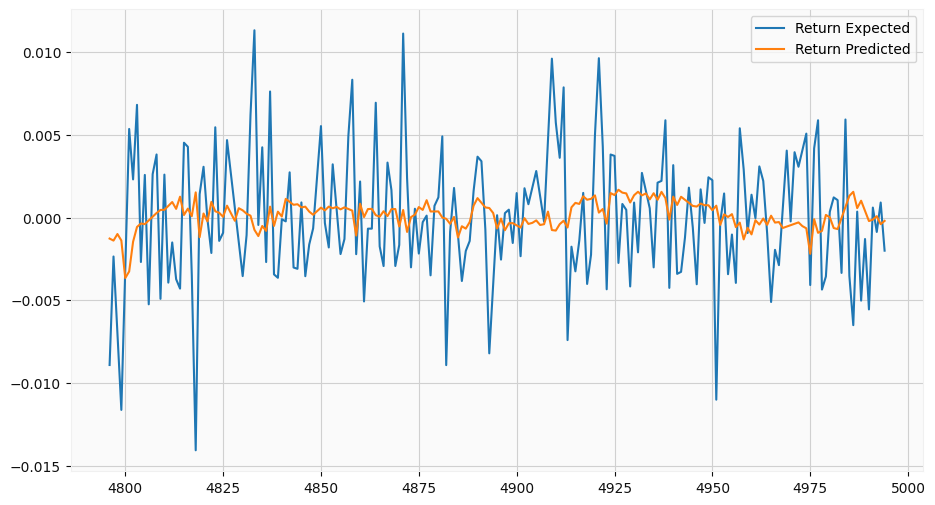

In [ ]:
f, axs = plt.subplots( figsize=(11, 6))
df_pred_exp.iloc[-200:].plot(y="Return Expected",ax=axs)
df_pred_exp.iloc[-200:].plot(y="Return Predicted",ax=axs)